In [1]:
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
#!C:/Users/joey/anaconda3/python.exe -m pip install tensorflow

import tensorflow as tf
#from tensorflow.contrib import rnn

### Importing the data & doing some basic data cleaning

In [2]:
# LOADING GAUGE DATA
# Obtained from USGS wbesite from the Charleston area.

# Data Column Info:
#
# Date: Date of recording 'yyyy-mm-dd' recorded daily
#
# Gauge Height: Recorded height of the river from the station. (ft)

# Reading in the data
df = pd.read_csv('chasflood.csv', encoding='utf-8', sep='\t', on_bad_lines='skip')
df2 = pd.DataFrame()
df2['Date']= df['3']
df2['Gauge_Height'] = df['22']

# view number of null entries
print(df2.isna().sum())
print(df2.shape)


# getting rid of some bad data
df2 = df2[df2['Date'] != '20d']
df2 = df2[df2['Date'] != '2022-03-15']
df2 = df2[df2['Date'] != '2022-03-16']

# drop the null entries
df2 = df2.dropna()

# set datetime index
df2['Date'] = pd.to_datetime(df2.Date)
df2 = df2.set_index('Date')
df2 = df2.resample('1D').mean().interpolate()

# print the dataset
print(df2)





Date              0
Gauge_Height    312
dtype: int64
(13225, 2)
            Gauge_Height
Date                    
1986-10-01         17.81
1986-10-02         17.77
1986-10-03         17.85
1986-10-04         17.81
1986-10-05         17.71
...                  ...
2022-03-10         18.08
2022-03-11         18.44
2022-03-12         17.33
2022-03-13         17.61
2022-03-14         17.80

[12949 rows x 1 columns]


In [3]:
# LOADING PRECIPITATION DATA & CLEANING
#
# The data was taken from NOAA's rainfall database recorded daily
#
# Column Info: 
#
# Date: date of recording 'yyyy-mm-dd' recorded daily
# 
# Precip: precipitation totals recorded daily (inches)

# read in data
df3 = pd.read_csv('chas_rainfall.csv')
df4 = pd.DataFrame()
df4['Date'] = df3['DATE']
df4['Precip'] = df3['PRCP']

# remove some bad data & fix data types
df4['Date'] = pd.to_datetime(df4.Date)
df4 = df4[df4['Date'] >= '1986-10-01']

# set date time index
df4 = df4.set_index('Date')

print(df4.shape)
print(df4)

(12949, 1)
            Precip
Date              
1986-10-01    0.00
1986-10-02    0.00
1986-10-03    0.00
1986-10-04    0.00
1986-10-05    0.00
...            ...
2022-03-10    0.15
2022-03-11    0.00
2022-03-12    0.05
2022-03-13    0.00
2022-03-14    0.00

[12949 rows x 1 columns]


In [173]:
# COMBINING PRECIP & GAUGE HEIGHT ON DATE

cdf = df4
cdf['Gauge_Height'] = df2['Gauge_Height']

print(cdf.dtypes)

print(cdf)

print("Number of unique Gauge Height observations: ")
print(pd.unique(cdf['Gauge_Height']).shape)

print("Number of unique Precipitation observations: ")
print(pd.unique(cdf['Precip']).shape)


Precip          float64
Gauge_Height    float64
dtype: object
            Precip  Gauge_Height
Date                            
1986-10-01    0.00         17.81
1986-10-02    0.00         17.77
1986-10-03    0.00         17.85
1986-10-04    0.00         17.81
1986-10-05    0.00         17.71
...            ...           ...
2022-03-10    0.15         18.08
2022-03-11    0.00         18.44
2022-03-12    0.05         17.33
2022-03-13    0.00         17.61
2022-03-14    0.00         17.80

[12949 rows x 2 columns]
Number of unique Gauge Height observations: 
(382,)
Number of unique Precipitation observations: 
(296,)


### Finding some interesting cases in the data:

In [5]:

idx = cdf['Gauge_Height'].idxmax()
print(idx)

print(cdf.loc['2017-09-11']) # date 1 to use for prediction

2017-09-11 00:00:00
Precip           5.51
Gauge_Height    20.96
Name: 2017-09-11 00:00:00, dtype: float64


In [6]:
idx = cdf['Gauge_Height'].idxmin()
print(idx)

print(cdf.loc['1993-03-14']) # date 2 to use for prediction

1993-03-14 00:00:00
Precip           0.00
Gauge_Height    15.33
Name: 1993-03-14 00:00:00, dtype: float64


In [7]:
idx = cdf['Precip'].idxmax()
print(idx)

print(cdf.loc['2015-10-03']) # date 3 to use for prediction

2015-10-03 00:00:00
Precip          11.5
Gauge_Height    20.2
Name: 2015-10-03 00:00:00, dtype: float64


### Visualizing the data

Plotting the data over time:

<AxesSubplot:xlabel='Date'>

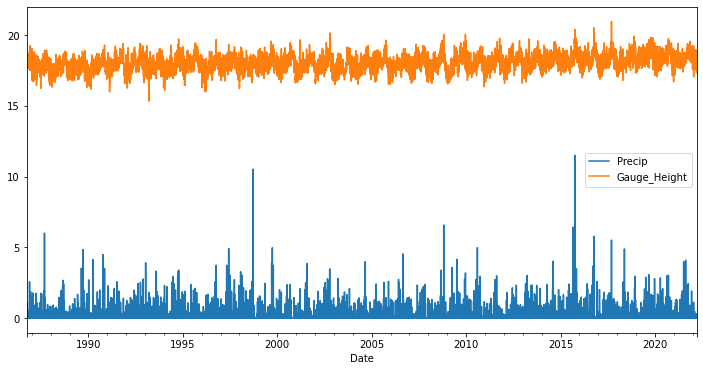

In [8]:
cdf.plot(figsize=(12,6))
# df = df[df['Guage Height'] != 0.00]
# df

Plotting the seasonal decomposition:

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

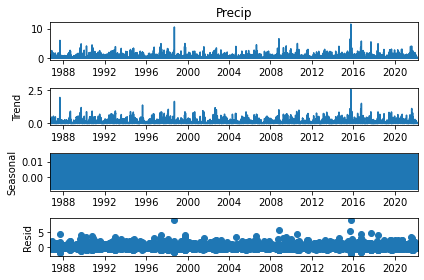

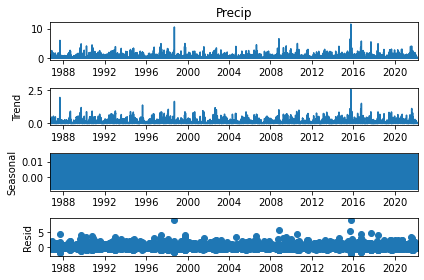

In [10]:
res = seasonal_decompose(cdf['Precip'])
res.plot()

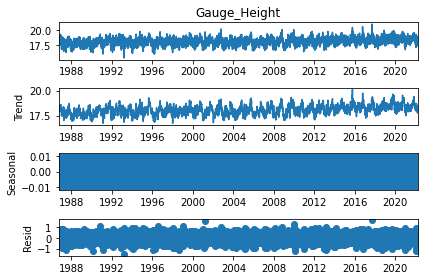

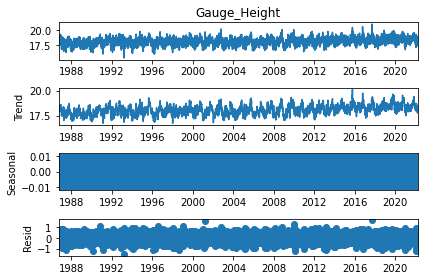

In [11]:
res = seasonal_decompose(cdf['Gauge_Height'])
res.plot()

In [12]:
len(cdf) # Number of entries

12949

In [13]:
# # Test previous year with rest of data
# train = cdf.iloc[:12584]
# test = cdf.iloc[12584:]

### Preparing data for machine learning and building model

In [14]:
# import scalers
from sklearn.preprocessing import MinMaxScaler
# separate scalers for guage height and precipitation used to read results
scalerP = MinMaxScaler()
scalerG = MinMaxScaler()

# scaler for both
scaler = MinMaxScaler()

Scaling the data:

In [15]:
pvals = cdf['Precip']
gvals = cdf['Gauge_Height']

scaledP = scalerP.fit_transform(pvals.values.reshape(-1,1))
scaledG = scalerG.fit_transform(gvals.values.reshape(-1,1))


In [16]:
# scale values
# scaler.fit(train)
# scaled_train = scaler.transform(train)
# scaled_test = scaler.transform(test)

# scaled_train[:10]

In [17]:
print(cdf)
vals = cdf.values
scaled = scaler.fit_transform(vals)
print(scaled)
unscaled = scaler.inverse_transform(scaled)
unscaled

            Precip  Gauge_Height
Date                            
1986-10-01    0.00         17.81
1986-10-02    0.00         17.77
1986-10-03    0.00         17.85
1986-10-04    0.00         17.81
1986-10-05    0.00         17.71
...            ...           ...
2022-03-10    0.15         18.08
2022-03-11    0.00         18.44
2022-03-12    0.05         17.33
2022-03-13    0.00         17.61
2022-03-14    0.00         17.80

[12949 rows x 2 columns]
[[0.         0.44049734]
 [0.         0.43339254]
 [0.         0.44760213]
 ...
 [0.00434783 0.35523979]
 [0.         0.40497336]
 [0.         0.43872114]]


array([[ 0.  , 17.81],
       [ 0.  , 17.77],
       [ 0.  , 17.85],
       ...,
       [ 0.05, 17.33],
       [ 0.  , 17.61],
       [ 0.  , 17.8 ]])

Explanation for function used

In [101]:

# FUNCTION FROM 
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# NOT MY WORK

from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [163]:
# Adding a variable including the previous day's flood data & rain data (input)
# predict current day's flooding (output)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var2(t)
1,0.000000,0.440497,0.433393
2,0.000000,0.433393,0.447602
3,0.000000,0.447602,0.440497
4,0.000000,0.440497,0.422735
5,0.000000,0.422735,0.495560
...,...,...,...
12944,0.005217,0.433393,0.488455
12945,0.013043,0.488455,0.552398
12946,0.000000,0.552398,0.355240
12947,0.004348,0.355240,0.404973


Split the scaled data into the testing and training sets

In [164]:
#get testing and training sets

values = reframed.values
len(values)

#predict future two years based of previous data
n_train_days = len(values) - (365*2)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

#split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#shape input to be 3D
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12218, 1, 2) (12218,) (730, 1, 2) (730,)


Build and fit the model

In [165]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# define and fit model!

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(50, return_sequences=True))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [167]:
# fit network

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
170/170 - 0s - loss: 0.0417 - val_loss: 0.0392 - 421ms/epoch - 2ms/step
Epoch 2/50
170/170 - 0s - loss: 0.0419 - val_loss: 0.0391 - 387ms/epoch - 2ms/step
Epoch 3/50
170/170 - 0s - loss: 0.0419 - val_loss: 0.0391 - 414ms/epoch - 2ms/step
Epoch 4/50
170/170 - 0s - loss: 0.0419 - val_loss: 0.0392 - 477ms/epoch - 3ms/step
Epoch 5/50
170/170 - 0s - loss: 0.0419 - val_loss: 0.0392 - 447ms/epoch - 3ms/step
Epoch 6/50
170/170 - 1s - loss: 0.0419 - val_loss: 0.0391 - 513ms/epoch - 3ms/step
Epoch 7/50
170/170 - 1s - loss: 0.0419 - val_loss: 0.0391 - 597ms/epoch - 4ms/step
Epoch 8/50
170/170 - 1s - loss: 0.0419 - val_loss: 0.0391 - 536ms/epoch - 3ms/step
Epoch 9/50
170/170 - 1s - loss: 0.0418 - val_loss: 0.0391 - 542ms/epoch - 3ms/step
Epoch 10/50
170/170 - 1s - loss: 0.0419 - val_loss: 0.0391 - 553ms/epoch - 3ms/step
Epoch 11/50
170/170 - 1s - loss: 0.0419 - val_loss: 0.0390 - 642ms/epoch - 4ms/step
Epoch 12/50
170/170 - 1s - loss: 0.0419 - val_loss: 0.0391 - 628ms/epoch - 4ms/step
E

In [146]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 50)                10600     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________


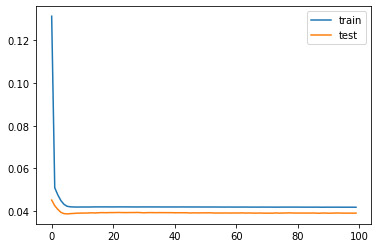

In [156]:
# plot results

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [157]:
print(test_X)
print(test_y.shape)

[[[0.         0.44937833]]

 [[0.         0.52575488]]

 [[0.         0.59325044]]

 ...

 [[0.         0.55239787]]

 [[0.00434783 0.35523979]]

 [[0.         0.40497336]]]
(730,)


In [159]:
from sklearn.metrics import mean_squared_error
# evaluate the model

yhat = model.predict(test_X)

print(test_X.shape)

print(yhat.shape)

(730, 1, 2)
(730, 1)


In [150]:
yhat = yhat.reshape(test_y.shape)

In [161]:
inv_pred = scalerP.inverse_transform(yhat.reshape(-1,1))

inv_test_y = scalerP.inverse_transform(test_y.reshape(-1,1))

rmse = np.sqrt(mean_squared_error(inv_test_y, inv_pred))

print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.620


In [160]:

#print("yhat from model.predict")
#print(yhat)

t1 = test_X.reshape((test_X.shape[0], 2))

print(t1[1, 1])

print(t1)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

print("reshaped test_X")
print(test_X)

#invert scaling to forecast

inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)

print("inv_yhat before transform")
print(inv_yhat)

inv_yhat = scaler.inverse_transform(inv_yhat)

print('after')
print(inv_yhat)

inv_yhat = inv_yhat[:, 0]

#change scaling back

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# calculate RMSE

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)

# off by about 0.622 ft, not bad!

0.525754884547069
[[0.         0.44937833]
 [0.         0.52575488]
 [0.         0.59325044]
 ...
 [0.         0.55239787]
 [0.00434783 0.35523979]
 [0.         0.40497336]]
reshaped test_X
[[0.         0.44937833]
 [0.         0.52575488]
 [0.         0.59325044]
 ...
 [0.         0.55239787]
 [0.00434783 0.35523979]
 [0.         0.40497336]]
inv_yhat before transform
[[0.46773177 0.44937833]
 [0.53316003 0.52575488]
 [0.59288985 0.59325044]
 ...
 [0.5565272  0.55239787]
 [0.39007708 0.35523979]
 [0.4307774  0.40497336]]
after
[[ 5.3789154  17.86      ]
 [ 6.13134035 18.29      ]
 [ 6.81823322 18.67      ]
 ...
 [ 6.40006277 18.44      ]
 [ 4.48588647 17.33      ]
 [ 4.95394011 17.61      ]]
Test RMSE: 0.620


In [29]:
# trying to make interesting predictions

pred_in = np.array([[20.0, 14.00]])
pred_in = scaler.transform(pred_in)
pred_in = pred_in.reshape(1, 1, 2)



pred_out = model.predict(pred_in)
print(scalerG.inverse_transform(pred_out))

[[15.006977]]


In [30]:
#print(cdf.loc[cdf['index'] >='2017-09-11']) # date 1 to use for prediction

dates = pd.date_range(end='2017-09-11', periods=7)

print(cdf.loc[dates])

datesy = pd.date_range(end='2017-09-18', periods=7)

drange = cdf.loc[dates]
drange = scaler.transform(drange.values)
drange = drange.reshape(7, 1, 2)

exy1 = model.predict(drange)

exy1

print(scalerG.inverse_transform(exy1))
#print(cdf.loc[datesy])

            Precip  Gauge_Height
Date                            
2017-09-05    0.14         18.61
2017-09-06    0.41         18.39
2017-09-07    0.00         18.50
2017-09-08    0.00         18.72
2017-09-09    0.00         19.26
2017-09-10    0.02         19.63
2017-09-11    5.51         20.96
[[18.606401]
 [18.40401 ]
 [18.51577 ]
 [18.708862]
 [19.192057]
 [19.529486]
 [20.524649]]


In [31]:
dates = pd.date_range(end='1993-03-14', periods=7)

print(cdf.loc[dates])

#datesy = pd.date_range(end='2017-09-18', periods=7)

drange = cdf.loc[dates]
drange = scaler.transform(drange.values)
drange = drange.reshape(7, 1, 2)

exy1 = model.predict(drange)

exy1

print(scalerG.inverse_transform(exy1))

            Precip  Gauge_Height
Date                            
1993-03-08    0.00         17.38
1993-03-09    0.00         17.28
1993-03-10    0.00         17.39
1993-03-11    0.00         16.94
1993-03-12    0.01         17.83
1993-03-13    0.93         16.85
1993-03-14    0.00         15.33
[[17.568878]
 [17.487404]
 [17.577053]
 [17.214323]
 [17.941488]
 [17.112944]
 [16.007483]]


In [32]:
dates = pd.date_range(end='2015-10-03', periods=7)

print(cdf.loc[dates])

#datesy = pd.date_range(end='2017-09-18', periods=7)

drange = cdf.loc[dates]
drange = scaler.transform(drange.values)
drange = drange.reshape(7, 1, 2)

exy1 = model.predict(drange)

exy1

print(scalerG.inverse_transform(exy1))

            Precip  Gauge_Height
Date                            
2015-09-27    0.00         19.55
2015-09-28    0.00         19.51
2015-09-29    0.00         19.35
2015-09-30    0.41         19.08
2015-10-01    1.37         19.14
2015-10-02    1.61         19.55
2015-10-03   11.50         20.20
[[19.456747]
 [19.420029]
 [19.273823]
 [19.0123  ]
 [19.026228]
 [19.386648]
 [19.585089]]
